In [2]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'resnet101_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! unzip -o /content/drive/MyDrive/dataset_19.zip
! unzip -o /content/drive/MyDrive/Brain_MRI.zip

! pwd

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/Tr-gl_0732.jpg  
  inflating: Training/glioma/

# Load the Data

In [5]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Testing"

# Data Distribution

In [6]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

pituitary     120
notumor       120
meningioma    120
glioma        120
dtype: int64

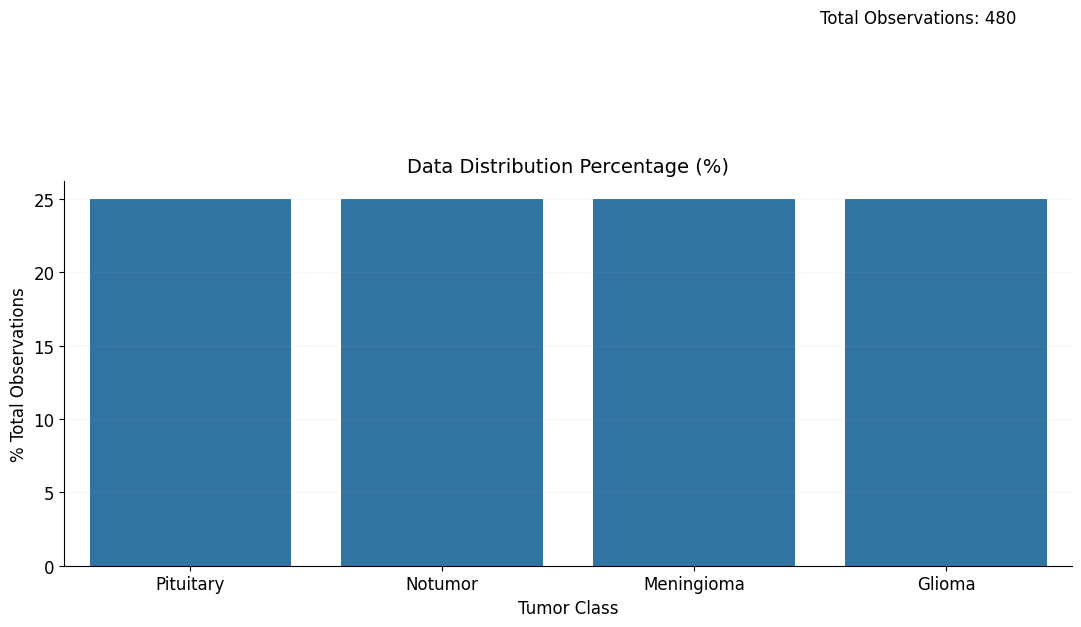

In [7]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Splitting the Data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


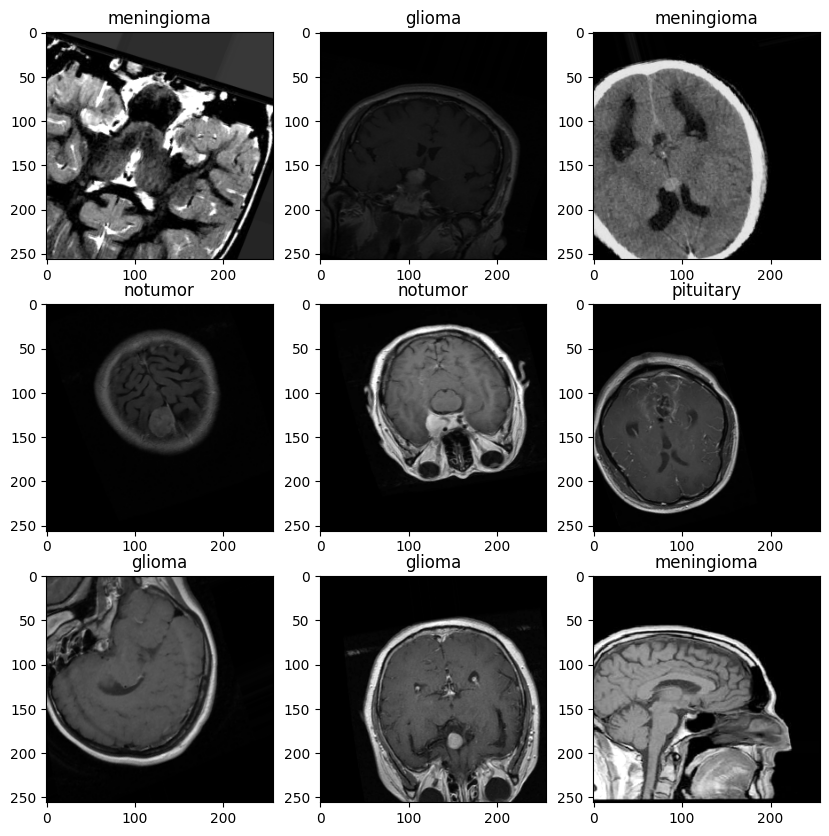

In [8]:
classes = os.listdir(dir)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range = [0.3, 1.5],
    fill_mode='nearest',
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(256, 256),
    batch_size=32,
    seed=42,
    subset='training'
)

test_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(256, 256),
    batch_size=32,
    seed=42,
    subset='validation')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    seed=42,
    batch_size=32
)

print(test_generator.class_indices)

# Display 1 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        # Print Class
        plt.title(classes[np.argmax(Y_batch[0])])

        plt.imshow(image)
        break



# Training a Vision Transformer (ViT) model

In [9]:
# # Define the model
# model_name = "google/vit-base-patch16-224"
# image_processor = ViTImageProcessor.from_pretrained(model_name)

# # Custom layer to wrap the HuggingFace ViT model
# class ViTLayer(tf.keras.layers.Layer):
#     def __init__(self, model_name, num_labels, **kwargs):
#         super(ViTLayer, self).__init__(**kwargs)
#         self.vit_model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True)

#     def call(self, inputs):
#         def forward(inputs):
#             inputs = torch.tensor(inputs.numpy(), dtype=torch.float32)
#             outputs = self.vit_model(pixel_values=inputs).logits
#             return outputs.detach().numpy()

#         outputs = tf.py_function(forward, [inputs], tf.float32)
#         outputs.set_shape((None, len(classes)))  # Set the shape explicitly
#         return outputs

# # Create a custom data generator that works with the ViTImageProcessor
# class CustomDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, generator, image_processor, batch_size=32, img_size=(256, 256)):
#         self.generator = generator
#         self.image_processor = image_processor
#         self.batch_size = batch_size
#         self.img_size = img_size

#     def __len__(self):
#         return len(self.generator)

#     def __getitem__(self, idx):
#         batch_x, batch_y = self.generator[idx]
#         # Apply image processor to batch images
#         batch_x = self.image_processor(images=[image for image in batch_x], return_tensors="tf")['pixel_values']
#         return batch_x, batch_y

# train_data_gen = CustomDataGenerator(train_generator, image_processor)
# val_data_gen = CustomDataGenerator(test_generator, image_processor)

# # Define the Keras model with the custom ViT layer
# inputs = tf.keras.layers.Input(shape=(256, 256, 3), dtype=tf.float32)
# outputs = ViTLayer(model_name=model_name, num_labels=len(classes))(inputs)
# model = tf.keras.Model(inputs, outputs)

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# # Checkpoint callback to save the best model
# checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# # Train the model
# history = model.fit(train_data_gen,
#                     epochs=10,
#                     validation_data=val_data_gen,
#                     callbacks=[checkpoint])

# # Load the best model
# model.load_weights("best_model.h5")

# # Evaluate the model
# val_loss, val_accuracy = model.evaluate(val_data_gen)
# print(f'Validation Loss: {val_loss}')
# print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# # Plot training history
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

# MLP

In [12]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Dense, Flatten
from keras.utils import plot_model

def create_mlp_model(input_shape, num_classes):
    inputs = Input(input_shape)
    x = Flatten()(inputs)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

num_classes = os.listdir(dir)

# Create a new model
model = create_mlp_model((256, 256, 3), len(num_classes))

plot_model(model, to_file= 'model.png', show_shapes=True, show_layer_names=True)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               100663808 
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 100828548 (384.63 MB)
Trainable params: 1008285

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.9959 - accuracy: 0.2943
Epoch 1: val_loss improved from inf to 1.87478, saving model to resnet101_brain_mri.keras
12/12 [==============================] - 28s 2s/step - loss: 1.9959 - accuracy: 0.2943 - val_loss: 1.8748 - val_accuracy: 0.2604
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.6275 - accuracy: 0.3750
Epoch 2: val_loss improved from 1.87478 to 1.40824, saving model to resnet101_brain_mri.keras
12/12 [==============================] - 29s 3s/step - loss: 1.6275 - accuracy: 0.3750 - val_loss: 1.4082 - val_accuracy: 0.3021
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.5801 - accuracy: 0.3672
Epoch 3: val_loss did not improve from 1.40824
12/12 [==============================] - 10s 806ms/step - loss: 1.5801 - accuracy: 0.3672 - val_loss: 1.6974 - val_accuracy: 0.2188
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 1.6579 - accuracy: 0.3125
Epo

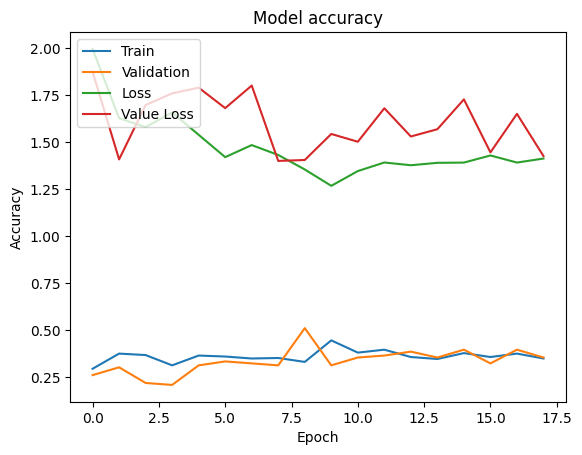

In [14]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()